In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

pd.options.display.max_columns = 100

In [2]:
data_train = pd.read_csv('data_model_train.csv')
data_test = pd.read_csv('data_model_test.csv')

data_train = data_train.iloc[:,1:]
data_test = data_test.iloc[:,1:]

In [3]:
# Check that both training and test 
print data_train.shape
print data_test.shape

(23896, 58)
(10240, 58)


In [4]:
# Training model
X = data_train.drop(['customer_no','Bad_label'],axis=1)
y = data_train.Bad_label

In [5]:
# Test model
X_actual = data_test.drop(['customer_no','Bad_label'],axis=1)
y_actual = data_test.Bad_label

In [6]:
# Replace any nan values with median
X = X.fillna(X.median())
X_actual = X_actual.fillna(X_actual.median())

In [7]:
X.shape

(23896, 56)

In [8]:
X_actual.shape

(10240, 56)

## Feature Importance

In [9]:
from sklearn.ensemble import RandomForestClassifier

features_label = X.columns
forest = RandomForestClassifier(n_estimators=1000, random_state=42, n_jobs=-1)
forest.fit(X,y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [10]:
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]
for i in range(X.shape[1]):
    print ("%2d) %-*s %f" % (i + 1, 30, features_label[i],importances[indices[i]]))

 1) dpd_29                         0.087657
 2) total_lastpy_opendt            0.086666
 3) min_months_last_30_plus        0.083871
 4) total cur_bal_amt/total credit limit 0.074727
 5) utilisation_trend              0.066975
 6) mean_lastpy_opendt             0.061485
 7) mean_paymt_his                 0.060982
 8) no_enq_365                     0.059618
 9) no_enq_90                      0.057491
10) max_freq_enq                   0.052018
11) ratio_sec/tot_enq              0.039603
12) days_pass_enq_dt               0.034754
13) age                            0.028122
14) feature_43_le                  0.020195
15) feature_38_le                  0.019907
16) feature_1_Golf Card            0.012354
17) feature_1_Insignia             0.012165
18) feature_1_Platinum Cricke      0.010757
19) feature_1_Platinum Deligh      0.010624
20) feature_1_Platinum Maxima      0.010528
21) feature_1_RBL Bank Fun+        0.010309
22) feature_1_Titanium Deligh      0.010030
23) feature_27_CA         

Selected top 15 features to be train and build baseline model. 

In [11]:
X = X[['dpd_29','total_lastpy_opendt','min_months_last_30_plus','total cur_bal_amt/total credit limit',
       'utilisation_trend','mean_lastpy_opendt','mean_paymt_his','no_enq_365','no_enq_90','max_freq_enq',
       'ratio_sec/tot_enq','days_pass_enq_dt','age','feature_43_le','feature_38_le']]

X_actual = X_actual[['dpd_29','total_lastpy_opendt','min_months_last_30_plus','total cur_bal_amt/total credit limit',
                     'utilisation_trend','mean_lastpy_opendt','mean_paymt_his','no_enq_365','no_enq_90','max_freq_enq',
                     'ratio_sec/tot_enq','days_pass_enq_dt','age','feature_43_le','feature_38_le']]

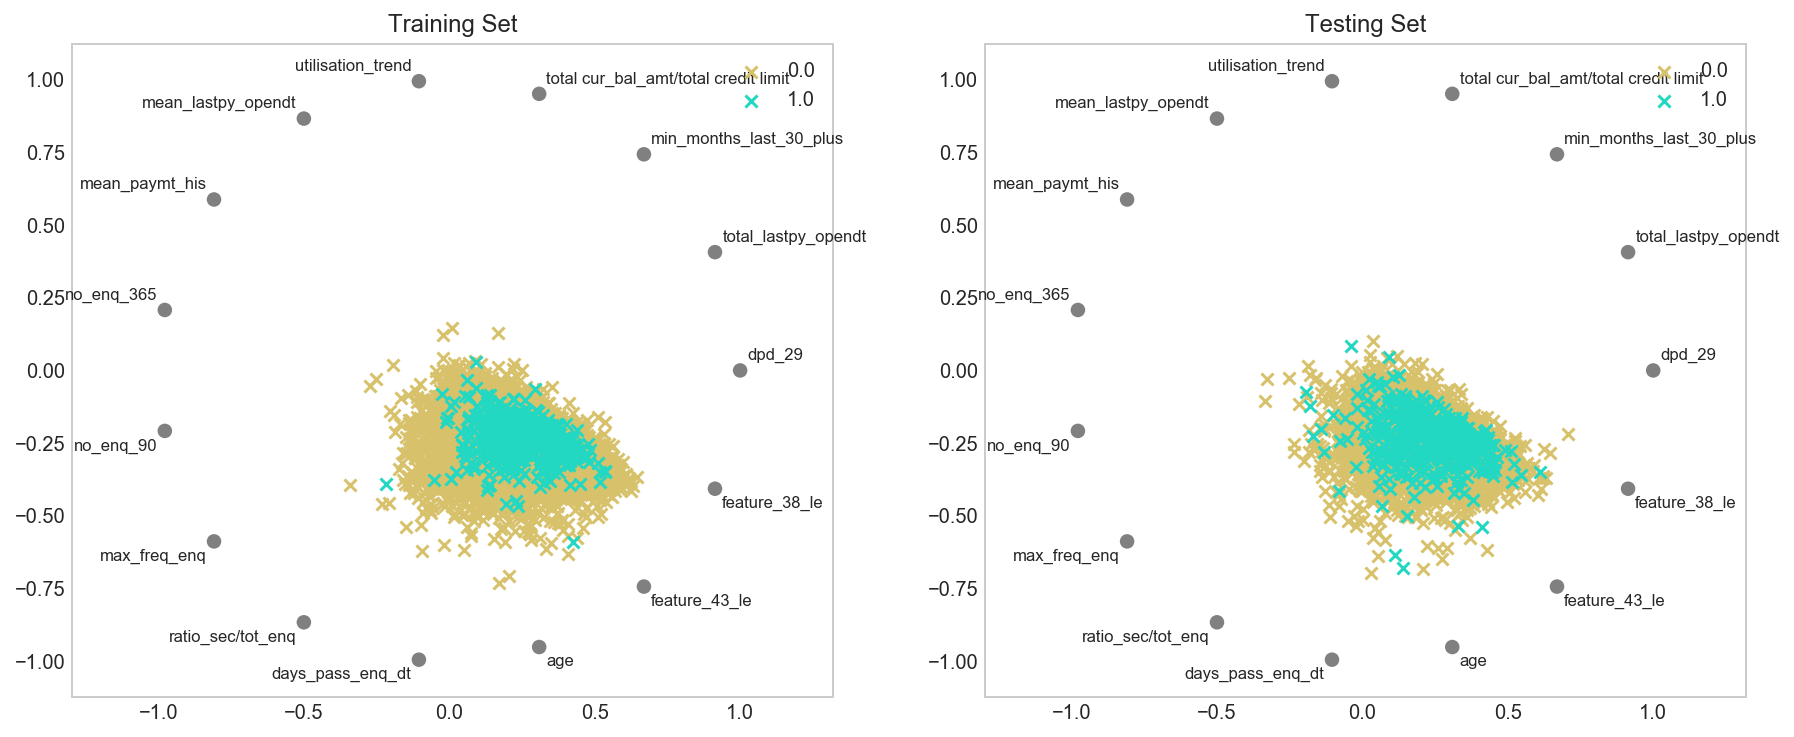

In [12]:
from pandas.plotting import radviz

fig, axes = plt.subplots(nrows=1, ncols=2)
ax1, ax2 = axes
fig.set_size_inches(15,6)

X_viz = X.copy()
X_viz2 = X_actual.copy()

X_viz['Bad_label'] = data_test['Bad_label']
X_viz2['Bad_label'] = data_test['Bad_label']

X_viz = X_viz.fillna(X_viz.median())
X_viz2 = X_viz2.fillna(X_viz2.median())

radviz(X_viz, 'Bad_label', marker='x', ax=ax1).grid(False)
ax1.set_title('Training Set')
radviz(X_viz2, 'Bad_label', marker='x', ax=ax2).grid(False)
ax2.set_title('Testing Set');

## Training Models

**Sampling**

In [13]:
from imblearn.combine import SMOTEENN

sme = SMOTEENN(random_state=42)
X_resampling, y_resampling = sme.fit_sample(X, y)

**Split training set**

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_resampling, y_resampling, test_size=0.3)

**Precision Recall Curve**

In [15]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, accuracy_score, classification_report

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])
    plt.figure(figsize=(8, 4))
    
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

**Logistic Regression**

In [16]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(penalty='l1')
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)
y_prob = logreg.predict_proba(X_test)[:,1]

fpr_lr, tpr_lr, thresholds = roc_curve(y_test, y_prob)
print "roc_auc_score:" ,roc_auc_score(y_test, y_prob)
print "accuracy:", accuracy_score(y_test, y_pred)
print "---------------------"

# print confusion matrix
train_actual = pd.Series(y_test, name='Actual')
train_predict = pd.Series(y_pred, name='Predicted')
df_confusion_t = pd.crosstab(train_actual, train_predict)
print df_confusion_t
print "----------------------------------------------------"

# Print classification report
print classification_report(y_test, y_pred)

roc_auc_score: 0.6711621384086754
accuracy: 0.6489837777363416
---------------------
Predicted   0.0   1.0
Actual               
0.0        2019  2642
1.0        1123  4942
----------------------------------------------------
             precision    recall  f1-score   support

        0.0       0.64      0.43      0.52      4661
        1.0       0.65      0.81      0.72      6065

avg / total       0.65      0.65      0.63     10726



**Decision Tree Classifier**

In [17]:
from sklearn.tree import DecisionTreeClassifier

dtree = DecisionTreeClassifier()
dtree.fit(X_train, y_train)

y_pred = dtree.predict(X_test)
y_prob = dtree.predict_proba(X_test)[:,1]

fpr_dtree, tpr_dtree, thresholds = roc_curve(y_test, y_prob)
print "roc_auc_score:" ,roc_auc_score(y_test, y_prob)
print "accuracy:", accuracy_score(y_test, y_pred)
print "---------------------"

# print confusion matrix
train_actual = pd.Series(y_test, name='Actual')
train_predict = pd.Series(y_pred, name='Predicted')
df_confusion_t = pd.crosstab(train_actual, train_predict)
print df_confusion_t
print "----------------------------------------------------"

# Print classification report
print classification_report(y_test, y_pred)

roc_auc_score: 0.9309651414545953
accuracy: 0.9332463173596868
---------------------
Predicted   0.0   1.0
Actual               
0.0        4258   403
1.0         313  5752
----------------------------------------------------
             precision    recall  f1-score   support

        0.0       0.93      0.91      0.92      4661
        1.0       0.93      0.95      0.94      6065

avg / total       0.93      0.93      0.93     10726



**RandomForest Classifer**

In [18]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:,1]

fpr_rf, tpr_rf, thresholds = roc_curve(y_test, y_prob)
print "roc_auc_score:" ,roc_auc_score(y_test, y_prob)
print "accuracy:", accuracy_score(y_test, y_pred)
print "---------------------"

# print confusion matrix
train_actual = pd.Series(y_test, name='Actual')
train_predict = pd.Series(y_pred, name='Predicted')
df_confusion_t = pd.crosstab(train_actual, train_predict)
print df_confusion_t
print "----------------------------------------------------"

# Print classification report
print classification_report(y_test, y_pred)

roc_auc_score: 0.9880751559174523
accuracy: 0.9625209770650756
---------------------
Predicted   0.0   1.0
Actual               
0.0        4577    84
1.0         318  5747
----------------------------------------------------
             precision    recall  f1-score   support

        0.0       0.94      0.98      0.96      4661
        1.0       0.99      0.95      0.97      6065

avg / total       0.96      0.96      0.96     10726



**Gradient Boost Classifier**

In [19]:
from sklearn.ensemble import GradientBoostingClassifier

gradbclass = GradientBoostingClassifier(n_estimators=100)
gradbclass.fit(X_train, y_train)

y_pred = gradbclass.predict(X_test)
y_prob = gradbclass.predict_proba(X_test)[:,1]

fpr_gb, tpr_gb, thresholds = roc_curve(y_test, y_prob)
print "roc_auc_score:" ,roc_auc_score(y_test, y_prob)
print "accuracy:", accuracy_score(y_test, y_pred)
print "---------------------"

# print confusion matrix
train_actual = pd.Series(y_test, name='Actual')
train_predict = pd.Series(y_pred, name='Predicted')
df_confusion_t = pd.crosstab(train_actual, train_predict)
print df_confusion_t
print "----------------------------------------------------"

# Print classification report
print classification_report(y_test, y_pred)

roc_auc_score: 0.9756333491516226
accuracy: 0.9369755733731121
---------------------
Predicted   0.0   1.0
Actual               
0.0        4524   137
1.0         539  5526
----------------------------------------------------
             precision    recall  f1-score   support

        0.0       0.89      0.97      0.93      4661
        1.0       0.98      0.91      0.94      6065

avg / total       0.94      0.94      0.94     10726



**Cross-Validation**

In [33]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import StratifiedKFold

k_fold = KFold(n_splits=5) # or shuffle=False

print 'logistric regression:', np.mean(cross_val_score(logreg, X_train, y_train, cv=k_fold, scoring='roc_auc'))
print 'decision tree:', np.mean(cross_val_score(dtree, X_train, y_train, cv=k_fold, scoring='roc_auc'))
print 'random forest:', np.mean(cross_val_score(rf, X_train, y_train, cv=k_fold, scoring='roc_auc'))
print 'gradient boosting:', np.mean(cross_val_score(gradbclass, X_train, y_train, cv=k_fold, scoring='roc_auc'))

logistric regression: 0.6753387004311128
decision tree: 0.9263336470129614
random forest: 0.9863779423752522
gradient boosting: 0.9754284937181378


**GridSearchCV - Logistic Regression**

In [34]:
from sklearn.model_selection import GridSearchCV

tuned_parameters = {'C': [0.1, 0.5, 1, 5, 10, 50, 100]}
clf = GridSearchCV(LogisticRegression(penalty='l2'), tuned_parameters, cv=10, scoring="roc_auc")
clf.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.1, 0.5, 1, 5, 10, 50, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [35]:
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:,1]

fpr_clf, tpr_clf, thresholds = roc_curve(y_test, y_prob)
print "roc_auc_score:" ,roc_auc_score(y_test, y_prob)
print "accuracy:", accuracy_score(y_test, y_pred)
print "---------------------"

# print confusion matrix
train_actual = pd.Series(y_test, name='Actual')
train_predict = pd.Series(y_pred, name='Predicted')
df_confusion_t = pd.crosstab(train_actual, train_predict)
print df_confusion_t
print "----------------------------------------------------"

# Print classification report
print classification_report(y_test, y_pred)

roc_auc_score: 0.6688849061152399
accuracy: 0.648610852134999
---------------------
Predicted   0.0   1.0
Actual               
0.0        1981  2680
1.0        1089  4976
----------------------------------------------------
             precision    recall  f1-score   support

        0.0       0.65      0.43      0.51      4661
        1.0       0.65      0.82      0.73      6065

avg / total       0.65      0.65      0.63     10726



## Voting Based Ensemble Model

In [36]:
from sklearn.ensemble import VotingClassifier
voteclass = VotingClassifier(estimators=[('graB', gradbclass),
                                         ('lr', logreg)], voting='soft',weights=[1,3])

voteclass = voteclass.fit(X_train, y_train)

In [37]:
y_pred = voteclass.predict(X_test)
y_prob = voteclass.predict_proba(X_test)[:,1]

fpr_vote, tpr_vote, thresholds = roc_curve(y_test, y_prob)
print "roc_auc_score:" ,roc_auc_score(y_test, y_prob)
print "accuracy:", accuracy_score(y_test, y_pred)
print "---------------------"

# print confusion matrix
train_actual = pd.Series(y_test, name='Actual')
train_predict = pd.Series(y_pred, name='Predicted')
df_confusion_t = pd.crosstab(train_actual, train_predict)
print df_confusion_t
print "----------------------------------------------------"

# Print classification report
print classification_report(y_test, y_pred)

roc_auc_score: 0.8965571962043888
accuracy: 0.8108334887190005
---------------------
Predicted   0.0   1.0
Actual               
0.0        3166  1495
1.0         534  5531
----------------------------------------------------
             precision    recall  f1-score   support

        0.0       0.86      0.68      0.76      4661
        1.0       0.79      0.91      0.85      6065

avg / total       0.82      0.81      0.81     10726



/Users/WenLin/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


## Test on actual dataset

**Voting Based Ensemble**

/Users/WenLin/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


roc_auc_score: 0.6096070868519222
accuracy: 0.4740234375
---------------------
Predicted   0.0   1.0
Actual               
0.0        4541  5237
1.0         149   313
----------------------------------------------------
             precision    recall  f1-score   support

        0.0       0.97      0.46      0.63      9778
        1.0       0.06      0.68      0.10       462

avg / total       0.93      0.47      0.60     10240



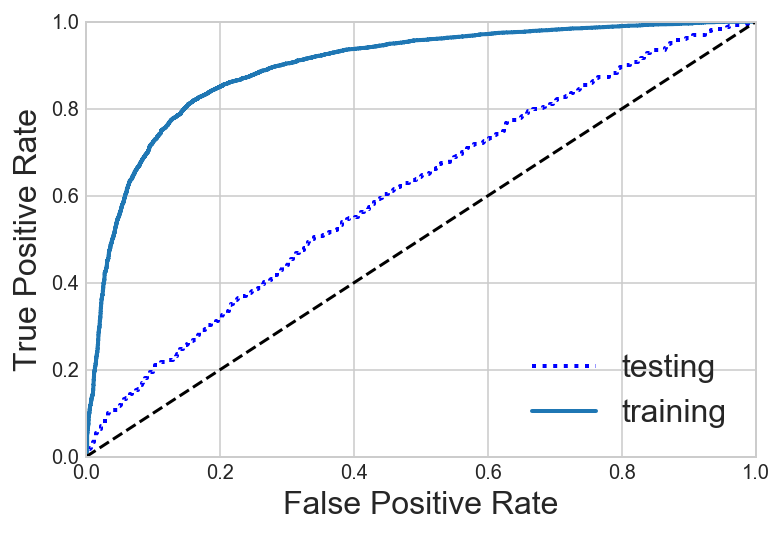

In [38]:
y_pred = voteclass.predict(X_actual)
y_prob = voteclass.predict_proba(X_actual)[:,1]

fpr_test, tpr_test, thresholds = roc_curve(y_actual, y_prob)
print "roc_auc_score:" ,roc_auc_score(y_actual, y_prob)
print "accuracy:", accuracy_score(y_actual, y_pred)
print "---------------------"

# print confusion matrix
train_actual = pd.Series(y_actual, name='Actual')
train_predict = pd.Series(y_pred, name='Predicted')
df_confusion_t = pd.crosstab(train_actual, train_predict)
print df_confusion_t
print "----------------------------------------------------"

# Print classification report
print classification_report(y_actual, y_pred)

# Print ROC curve
plt.figure(figsize=(6, 4))
plt.plot(fpr_test, tpr_test, "b:", linewidth=2, label="testing")
plot_roc_curve(fpr_vote, tpr_vote, "training")
plt.legend(loc="lower right", fontsize=16)
plt.show()

**Logistics Regression**

roc_auc_score: 0.621867360157399
accuracy: 0.4349609375
---------------------
Predicted   0.0   1.0
Actual               
0.0        4117  5661
1.0         125   337
----------------------------------------------------
             precision    recall  f1-score   support

        0.0       0.97      0.42      0.59      9778
        1.0       0.06      0.73      0.10       462

avg / total       0.93      0.43      0.57     10240



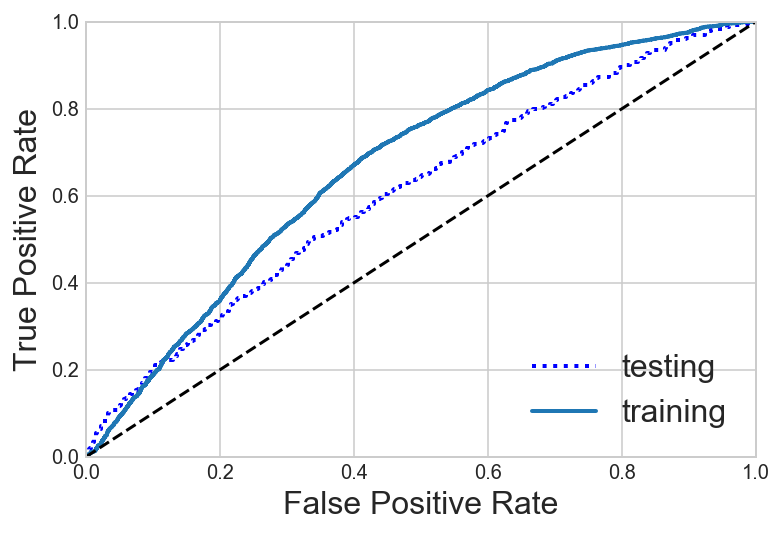

In [39]:
y_pred = logreg.predict(X_actual)
y_prob = logreg.predict_proba(X_actual)[:,1]

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_actual, y_prob)
print "roc_auc_score:" ,roc_auc_score(y_actual, y_prob)
print "accuracy:", accuracy_score(y_actual, y_pred)
print "---------------------"

# print confusion matrix
train_actual = pd.Series(y_actual, name='Actual')
train_predict = pd.Series(y_pred, name='Predicted')
df_confusion_t = pd.crosstab(train_actual, train_predict)
print df_confusion_t
print "----------------------------------------------------"

# Print classification report
print classification_report(y_actual, y_pred)

# Print ROC curve
plt.figure(figsize=(6, 4))
plt.plot(fpr_test, tpr_test, "b:", linewidth=2, label="testing")
plot_roc_curve(fpr_lr, tpr_lr, "training")
plt.legend(loc="lower right", fontsize=16)
plt.show()

**GridSearch - Logistic Regression**

roc_auc_score: 0.616852789945447
accuracy: 0.4439453125
---------------------
Predicted   0.0   1.0
Actual               
0.0        4216  5562
1.0         132   330
----------------------------------------------------
             precision    recall  f1-score   support

        0.0       0.97      0.43      0.60      9778
        1.0       0.06      0.71      0.10       462

avg / total       0.93      0.44      0.57     10240



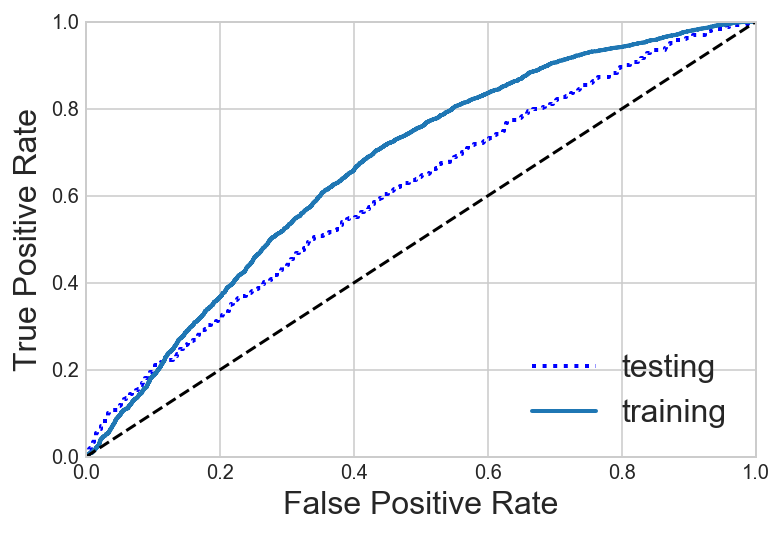

In [40]:
y_pred = clf.predict(X_actual)
y_prob = clf.predict_proba(X_actual)[:,1]

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_actual, y_prob)
print "roc_auc_score:" ,roc_auc_score(y_actual, y_prob)
print "accuracy:", accuracy_score(y_actual, y_pred)
print "---------------------"

# print confusion matrix
train_actual = pd.Series(y_actual, name='Actual')
train_predict = pd.Series(y_pred, name='Predicted')
df_confusion_t = pd.crosstab(train_actual, train_predict)
print df_confusion_t
print "----------------------------------------------------"

# Print classification report
print classification_report(y_actual, y_pred)

# Print ROC curve
plt.figure(figsize=(6, 4))
plt.plot(fpr_test, tpr_test, "b:", linewidth=2, label="testing")
plot_roc_curve(fpr_clf, tpr_clf, "training")
plt.legend(loc="lower right", fontsize=16)
plt.show()

**Decision Tree Classifier**

roc_auc_score: 0.5047573446530288
accuracy: 0.84384765625
---------------------
Predicted   0.0   1.0
Actual               
0.0        8580  1198
1.0         401    61
----------------------------------------------------
             precision    recall  f1-score   support

        0.0       0.96      0.88      0.91      9778
        1.0       0.05      0.13      0.07       462

avg / total       0.91      0.84      0.88     10240



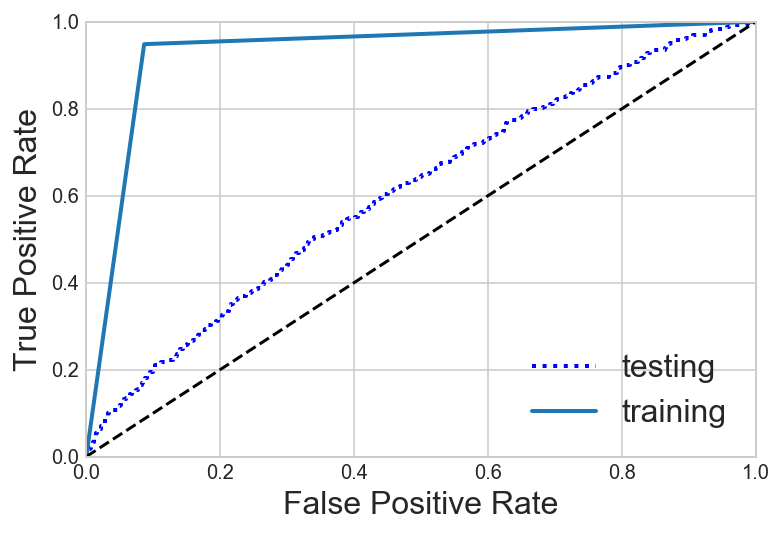

In [41]:
y_pred = dtree.predict(X_actual)
y_prob = dtree.predict_proba(X_actual)[:,1]

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_actual, y_prob)
print "roc_auc_score:" ,roc_auc_score(y_actual, y_prob)
print "accuracy:", accuracy_score(y_actual, y_pred)
print "---------------------"

# print confusion matrix
train_actual = pd.Series(y_actual, name='Actual')
train_predict = pd.Series(y_pred, name='Predicted')
df_confusion_t = pd.crosstab(train_actual, train_predict)
print df_confusion_t
print "----------------------------------------------------"

# Print classification report
print classification_report(y_actual, y_pred)

# Print ROC curve
plt.figure(figsize=(6, 4))
plt.plot(fpr_test, tpr_test, "b:", linewidth=2, label="testing")
plot_roc_curve(fpr_dtree, tpr_dtree, "training")
plt.legend(loc="lower right", fontsize=16)
plt.show()

**Random Forest Classifier**

roc_auc_score: 0.546309787233289
accuracy: 0.7599609375
---------------------
Predicted   0.0   1.0
Actual               
0.0        7678  2100
1.0         358   104
----------------------------------------------------
             precision    recall  f1-score   support

        0.0       0.96      0.79      0.86      9778
        1.0       0.05      0.23      0.08       462

avg / total       0.91      0.76      0.83     10240



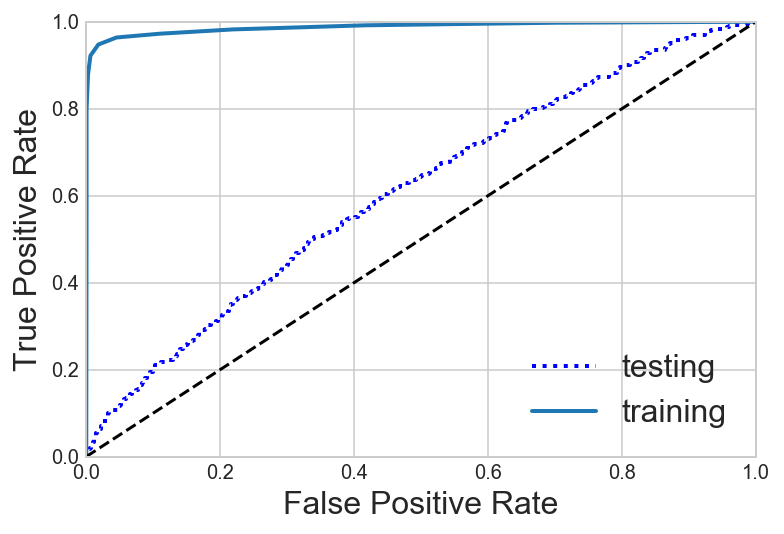

In [42]:
y_pred = rf.predict(X_actual)
y_prob = rf.predict_proba(X_actual)[:,1]

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_actual, y_prob)
print "roc_auc_score:" ,roc_auc_score(y_actual, y_prob)
print "accuracy:", accuracy_score(y_actual, y_pred)
print "---------------------"

# print confusion matrix
train_actual = pd.Series(y_actual, name='Actual')
train_predict = pd.Series(y_pred, name='Predicted')
df_confusion_t = pd.crosstab(train_actual, train_predict)
print df_confusion_t
print "----------------------------------------------------"

# Print classification report
print classification_report(y_actual, y_pred)

# Print ROC curve
plt.figure(figsize=(6, 4))
plt.plot(fpr_test, tpr_test, "b:", linewidth=2, label="testing")
plot_roc_curve(fpr_rf, tpr_rf, "training")
plt.legend(loc="lower right", fontsize=16)
plt.show()

**Gradient Boost Classifier**

roc_auc_score: 0.545624996126121
accuracy: 0.548046875
---------------------
Predicted   0.0   1.0
Actual               
0.0        5372  4406
1.0         222   240
----------------------------------------------------
             precision    recall  f1-score   support

        0.0       0.96      0.55      0.70      9778
        1.0       0.05      0.52      0.09       462

avg / total       0.92      0.55      0.67     10240



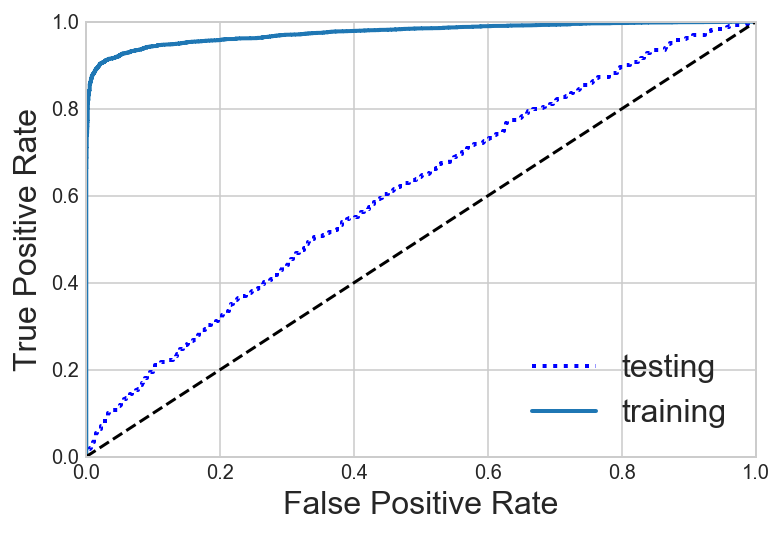

In [43]:
y_pred = gradbclass.predict(X_actual)
y_prob = gradbclass.predict_proba(X_actual)[:,1]

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_actual, y_prob)
print "roc_auc_score:" ,roc_auc_score(y_actual, y_prob)
print "accuracy:", accuracy_score(y_actual, y_pred)
print "---------------------"

# print confusion matrix
train_actual = pd.Series(y_actual, name='Actual')
train_predict = pd.Series(y_pred, name='Predicted')
df_confusion_t = pd.crosstab(train_actual, train_predict)
print df_confusion_t
print "----------------------------------------------------"

# Print classification report
print classification_report(y_actual, y_pred)

# Print ROC curve
plt.figure(figsize=(6, 4))
plt.plot(fpr_test, tpr_test, "b:", linewidth=2, label="testing")
plot_roc_curve(fpr_gb, tpr_gb, "training")
plt.legend(loc="lower right", fontsize=16)
plt.show()

**Model Evaluation -  Lift Chart**

It can be seen clearly that logistic regression gave the best performance among the rest with an AUC score of 0.62, tree, ensemble method and boosting classifiers lead to overfitting and does not show clear improvement on the testing set. Unfortunately, in credit risk an AUC of 0.75 or higher is the industry accepted standard and prerequisite to model acceptance, so clearly there is room for improvement

In [44]:
def calc_lift(x,y,clf,bins=10):
    """
    Takes input arrays and trained SkLearn Classifier and returns a Pandas
    DataFrame with the average lift generated by the model in each bin
    
    Parameters
    -------------------
    x:    Numpy array or Pandas Dataframe with shape = [n_samples, n_features]

    y:    A 1-d Numpy array or Pandas Series with shape = [n_samples]
          IMPORTANT: Code is only configured for binary target variable
          of 1 for success and 0 for failure
        
    clf:  A trained SkLearn classifier object
    bins: Number of equal sized buckets to divide observations across
          Default value is 10
    """

    #Actual Value of y
    y_actual = y
    #Predicted Probability that y = 1
    y_prob = clf.predict_proba(x)
    #Predicted Value of Y
    y_pred = clf.predict(x)
    cols = ['Actual','Prob_Positive','Predicted']
    data = [y_actual,y_prob[:,1],y_pred]
    df = pd.DataFrame(dict(zip(cols,data)))
    
    #Observations where y=1
    total_positive_n = df['Actual'].sum()
    #Total Observations
    total_n = df.index.size
    natural_positive_prob = total_positive_n/float(total_n)


    #Create Bins where First Bin has Observations with the
    #Highest Predicted Probability that y = 1
    df['Bin_Positive'] = pd.qcut(df['Prob_Positive'],bins,labels=False)
    
    pos_group_df = df.groupby('Bin_Positive')
    #Percentage of Observations in each Bin where y = 1 
    lift_positive = pos_group_df['Actual'].sum()/pos_group_df['Actual'].count()
    lift_index_positive = (lift_positive/natural_positive_prob)*100
    
    
    #Consolidate Results into Output Dataframe
    lift_df = pd.DataFrame({'Lift_positive':lift_positive,
                            'Lift_positive_index':lift_index_positive,
                            'Baseline_positive':natural_positive_prob})
    
    return lift_df

In [45]:
model_lift = calc_lift(X_actual,y_actual,logreg,bins=10)
model_lift

,Baseline_positive,Lift_positive,Lift_positive_index
Bin_Positive,,,
0,0.045117,0.019531,43.290043
1,0.045117,0.028320,62.770563
2,0.045117,0.035156,77.922078
3,0.045117,0.033203,73.593074
4,0.045117,0.038086,84.415584
5,0.045117,0.045898,101.731602
6,0.045117,0.041992,93.073593
7,0.045117,0.057617,127.705628
8,0.045117,0.056641,125.541126


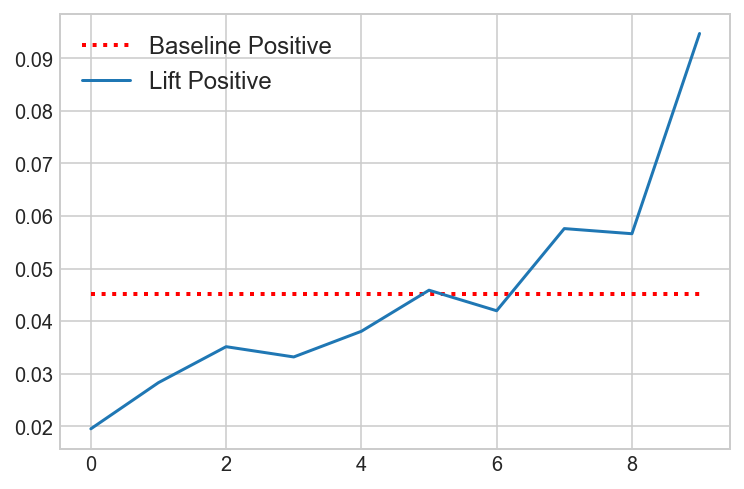

In [46]:
plt.figure(figsize=(6, 4))
plt.plot(model_lift.Baseline_positive, 'r:',label='Baseline Positive',linewidth=2)
plt.plot(model_lift.Lift_positive, label='Lift Positive')
plt.legend(loc="upper left", fontsize=12)

The lift analysis shows some flaws, there are a few small noticable peaks which shows that the model does not reflect reality well. But overall,logistic regression performs within expectations as shown at the rightmost bucket is highest.

**Future Work (In-progress)**

- Explain/justify why model is underperforming what can be done (certain information from the demographic data was ommitted preventing feature generation)
- Implement a credit scorecard / an example dependent cost-sensitive classifier to evaluate the model in business context. 